In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

2022-07-07 11:55:52.165374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 11:55:52.165402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

/tmp/ipykernel_22209/2647822554.py:5: RuntimeWarning: invalid value encountered in power
  * x**slope


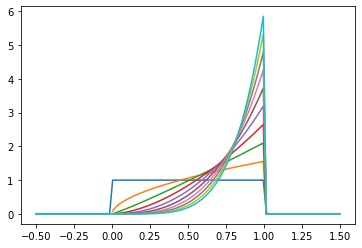

In [3]:
lo = 0
hi = 1
x = np.linspace(lo-.5, hi+.5, 100)

for slope in np.linspace(0, 5, 10):
    plt.plot(x, powerlaw(x, slope, lo, hi))

In [4]:
n_slopes = 10
n_samples = 1000
lo = 0
hi = 1

slopes = np.linspace(0, 5, n_slopes)
data = sample_powerlaw(n_samples, slopes[:, None], lo, hi)
data.shape

(10, 1000)

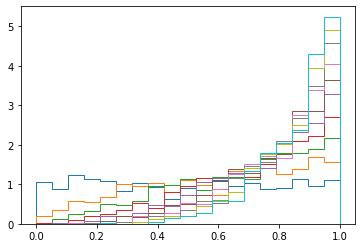

In [5]:
bins = np.linspace(lo, hi, 20)
for d in data:
    plt.hist(d, bins=bins, density=True, histtype='step')

In [6]:
slopes = np.repeat(slopes[:, None], n_samples, axis=1)
slopes.shape

(10, 1000)

In [7]:
data = np.concatenate(data)
slopes = np.concatenate(slopes)
data.shape, slopes.shape

((10000,), (10000,))

In [8]:
# Let's try adding a useless dimension so we can permute
# This means sampling will still work, but density evaluation won't
# We need some way to marginalize out the fake dimension
data = np.array([data, np.zeros(data.size)]).T
data.shape

(10000, 2)

In [9]:
# https://github.com/tensorflow/probability/issues/1410
# https://github.com/tensorflow/probability/issues/1006#issuecomment-663141106

import re

def make_bijector_kwargs(bijector, name_to_kwargs):
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

In [10]:
n_flows = 3
n_layers = 1
n_units = 128
activation = 'relu'

bijectors = []

#bijectors.append(tfb.BatchNormalization())

# We transform at the end with a logistic function
# This ensures all samples are in [0, 1]
bs = [
    tfb.Chain([tfb.Scale(scale=.5), tfb.Shift(shift=1.), tfb.Tanh()]),
    tfb.Identity(),
    ]
blockwise = tfb.Blockwise(bs, block_sizes=[1, 1])
bijectors.append(blockwise)

for i in range(n_flows):

    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=(2,),
        conditional=True,
        conditional_event_shape=(1,),
        #conditional_input_layers='all_layers',
        hidden_units=[n_units]*n_layers,
        #input_order='left-to-right',
        #hidden_degrees='equal',
        activation=activation,
        #use_bias=True,
        #kernel_initializer='glorot_uniform',
        #bias_initializer='zeros',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6),
        # bias_regularizer=tf.keras.regularizers.L2(l2=1e-6),
        #kernel_constraint=None,
        #bias_constraint=None,
        #validate_args=False,
        )
    maf = tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}')
    bijectors.append(maf)
    
    #bijectors.append(tfb.BatchNormalization())
    # bn = tfb.BatchNormalization(
    #     batchnorm_layer=tfk.layers.BatchNormalization(
    #         momentum=0.,
    #         epsilon=1e-5,
    #         center=True,
    #         scale=True,
    #         gamma_constraint=tf.math.exp,
    #         ),
    #     training=True,
    #     )
    # bijectors.append(bn)

    bijectors.append(tfb.Permute([1, 0]))

bijector = tfb.Chain(bijectors)
distribution = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2])                           
nf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)

2022-07-07 11:55:54.572402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-07 11:55:54.572432: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-07 11:55:54.572450: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phy-190401): /proc/driver/nvidia/version does not exist
2022-07-07 11:55:54.572776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
x = tf.keras.Input(shape=(2,), dtype=tf.float32)
c = tf.keras.Input(shape=(1,), dtype=tf.float32)

log_prob = nf.log_prob(
    x,
    bijector_kwargs=make_bijector_kwargs(
        nf.bijector, {'maf.': {'conditional_input': c}},
        ),
    )

model = tf.keras.Model([x, c], log_prob)

In [12]:
epochs = 20
batch_size = 100
learning_rate = 1e-3

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=lambda _, log_prob: -log_prob,
    )

result = model.fit(
    x=[data, slopes],
    y=np.zeros(n_samples*n_slopes, dtype=np.float32),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    )

Epoch 1/20
100/100 [==============================] - 2s 3ms/step - loss: 6205.1162
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 1.7678
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: -1.6391
Epoch 4/20
100/100 [==============================] - 0s 3ms/step - loss: -2.5612
Epoch 5/20
100/100 [==============================] - 0s 3ms/step - loss: -2.8960
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: -3.4416
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: -3.2898
Epoch 8/20
100/100 [==============================] - 0s 4ms/step - loss: -3.5685
Epoch 9/20
100/100 [==============================] - 0s 3ms/step - loss: -3.5543
Epoch 10/20
100/100 [==============================] - 0s 3ms/step - loss: -2.5322
Epoch 11/20
100/100 [==============================] - 0s 4ms/step - loss: -1.8138
Epoch 12/20
100/100 [==============================] - 0s 4ms/step - loss: 5.9716
Epoch 13/20
1

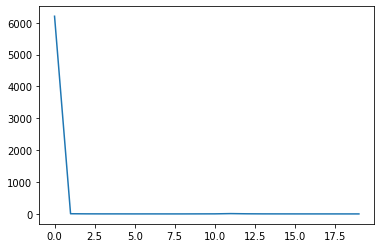

In [13]:
plt.plot(result.history['loss']);

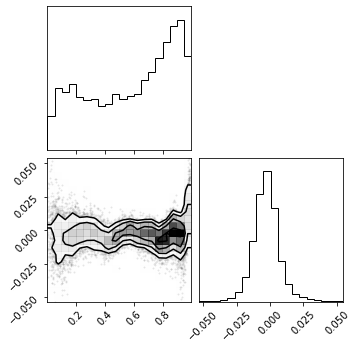

In [43]:
slope = 0
n_samples = 10000

condition = slope * np.ones((n_samples, 1))
bijector_kwargs = {
    f'maf{i}': {'conditional_input': condition} 
    for i in range(n_flows)
    }

corner(
    nf.sample(
        n_samples,
        bijector_kwargs=bijector_kwargs,
        ).numpy(),
    );

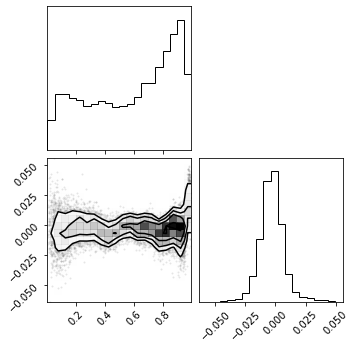

In [44]:
slope = 0
n_samples = 10000

condition = slope * np.ones((n_samples, 1))
bijector_kwargs = {
    f'maf{i}': {'conditional_input': condition} 
    for i in range(n_flows)
    }

corner(
    nf.bijector.forward(
        distribution.sample(n_samples),
        **bijector_kwargs,
        ).numpy(),
    );

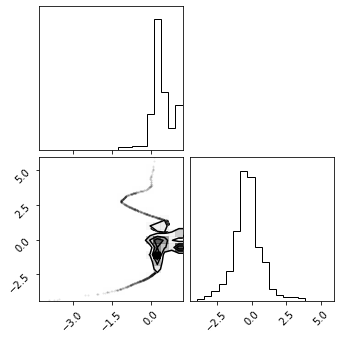

In [48]:
slope = 0
n_samples = 10000

condition = slope * np.ones((n_samples, 1))
samples = np.array([
    sample_powerlaw(n_samples, slope, lo, hi),
    np.zeros(n_samples),
    ]).T

bijector_kwargs = {
    f'maf{i}': {'conditional_input': condition} 
    for i in range(n_flows)
    }

corner(
    nf.bijector.inverse(
        samples,
        **bijector_kwargs,
        ).numpy(),
    );